# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size,frame_count, img_y, img_z):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,frame_count)).astype(int)#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,frame_count, img_y, img_z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                                       
                    # Cropped image of above dimension 
                    
                    #image = image.crop((0, 0, 120, 120))
                    image_resized=imresize(image,(img_y, img_z,3))
                    
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] =(image_resized[:,:,0])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =(image_resized[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image_resized[:,:,2])/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        remain_seq=len(t)%batch_size
        if (remain_seq != 0):
            batch_size = remain_seq if remain_seq else batch_size
        
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data = np.zeros((batch_size,frame_count, img_y, img_z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder

                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        # Cropped image of above dimension 

                        #image = image.crop((0, 0, 120, 120))
                        image_resized=imresize(image,(img_y, img_z,3))


                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes

                        batch_data[folder,idx,:,:,0] =(image_resized[:,:,0])/255#normalise and feed in the image
                        batch_data[folder,idx,:,:,1] =(image_resized[:,:,1])/255#normalise and feed in the image
                        batch_data[folder,idx,:,:,2] =(image_resized[:,:,2])/255#normalise and feed in the image

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels 

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Base Model

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers

#write your model here
class Conv3d_1(tf.keras.Model):
    
    def define_model(frame_count, img_y, img_z):
        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',input_shape=(frame_count, img_y, img_z, 3)))
        model.add(Activation('relu'))
        
        model.add(Conv3D(32, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Conv3D(64, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))
 
        model.add(Conv3D(128, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Flatten())           
        model.add(Dense(5,activation='softmax'))

        optimiser = optimizers.Adam()#write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [7]:
# custom parmeter
frame_count=10
img_y =100
img_z =100
num_epochs = 10
Conv3d_1_model= Conv3d_1.define_model(frame_count,img_y,img_z)
print (Conv3d_1_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 10, 100, 100, 16)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 100, 100, 32)  4128      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 100, 100, 32)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 100, 100, 32)  128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 50, 50, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 50, 50, 64)     1

#### Creating a function so can be called with dynamic parameter

In [7]:
def model_run(model,train_path,train_doc,val_path, val_doc,batch_size,frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs):
    print('frame_count=',frame_count)
    train_generator = generator(train_path, train_doc, batch_size,frame_count,img_y,img_z)
    val_generator = generator(val_path, val_doc, batch_size,frame_count,img_y,img_z)
    
# Model Saving & Checkpoint
    model_name = 'Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    
    eStop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
    
    callbacks_list = [checkpoint, LR,eStop]
    
    
#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
#Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

## Model 1 - Conv3D

In [9]:
history_1 = model_run(Conv3d_1_model,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

W0503 06:46:35.109513 139948036327232 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


frame_count= 10
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.9249 - categorical_accuracy: 0.2670
Epoch 00001: saving model to Gesture_recog_2021-05-0306_46_24.763657/model-00001-1.92490-0.26697-1.58729-0.22000.h5
23/23 [==============================] - 29s 1s/step - loss: 1.9249 - categorical_accuracy: 0.2670 - val_loss: 1.5873 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.4784 - categorical_accuracy: 0.4058
Epoch 00002: saving model to Gesture_recog_2021-05-0306_46_24.763657/model-00002-1.47837-0.40580-1.58719-0.15000.h5
23/23 [==============================] - 5s 202ms/step - loss: 1.4784 - categorical_accuracy: 0.4058 - val_loss: 1.5872 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.5247 - categorical_accuracy: 0.3333
Epoch 00003: saving model to Gesture_recog_2021-05-0306_46_24.763657/model-00003-1.52473-0.33333-1.5

In [8]:
# function to plot the training/validation accuracies/losses.
import matplotlib.pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

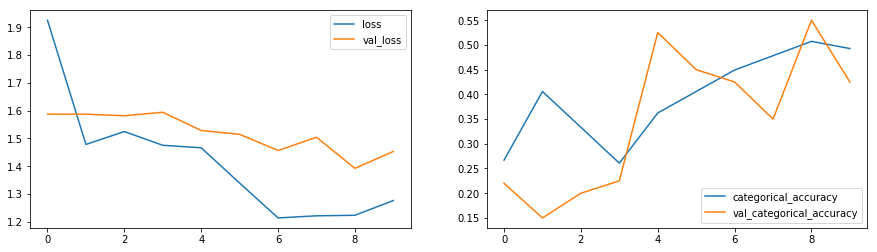

In [11]:
plot(history_1)

#### So with this sample model we see that the training accuracy is around 49% while val accuracy is around 42% so we can increase the epochs & image resolution.

## Model 2 - Conv3d

### With 15 epochs & 120 x 120 image res

In [11]:
# custom parmeter
frame_count=10
img_y =120
img_z =120
num_epochs = 15
batch_size = 30
Conv3d_2_model= Conv3d_1.define_model(frame_count,img_y,img_z)
print (Conv3d_2_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 10, 120, 120, 16)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 120, 120, 32)  4128      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 60, 60, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 60, 60, 64)     1

In [12]:
history_2 = model_run(Conv3d_2_model,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

W0502 19:57:15.258259 139774090102592 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


frame_count= 10
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 2.4825 - categorical_accuracy: 0.1840
Epoch 00001: val_loss improved from inf to 1.59429, saving model to Gesture_recog_2021-05-0219_55_32.561010/model-00001-2.48253-0.18401-1.59429-0.22000.h5
23/23 [==============================] - 108s 5s/step - loss: 2.4825 - categorical_accuracy: 0.1840 - val_loss: 1.5943 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.5205 - categorical_accuracy: 0.3043
Epoch 00002: val_loss improved from 1.59429 to 1.58220, saving model to Gesture_recog_2021-05-0219_55_32.561010/model-00002-1.52049-0.30435-1.58220-0.27500.h5
23/23 [==============================] - 6s 252ms/step - loss: 1.5205 - categorical_accuracy: 0.3043 - val_loss: 1.5822 - val_categorical_accuracy: 0.2750 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.6280 - categorical_accuracy: 0.3188
Epoch 00003: val_

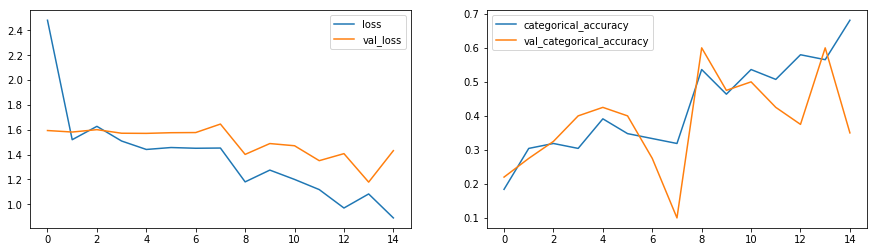

In [15]:
plot(history_2)

### So with this we see that the training accuracy has increased to around 68% while val accuracy has reduced to 35%.

## Model 3 - Conv3d

### Lets check increasing frame_count while reducing batch_size

In [16]:
# custom parmeter
frame_count=16
img_y =120
img_z =120
num_epochs = 15
batch_size = 15
Conv3d_3_model= Conv3d_1.define_model(frame_count,img_y,img_z)
print (Conv3d_3_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 16, 120, 120, 32)  4128      
_________________________________________________________________
activation_17 (Activation)   (None, 16, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 60, 60, 32)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 60, 60, 64)    

In [17]:
history_3 = model_run(Conv3d_3_model,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

W0502 20:07:11.370138 139774090102592 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


frame_count= 16
Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 2.3733 - categorical_accuracy: 0.2112
Epoch 00001: val_loss improved from inf to 1.60365, saving model to Gesture_recog_2021-05-0219_55_32.561010/model-00001-2.37328-0.21116-1.60365-0.31000.h5
45/45 [==============================] - 127s 3s/step - loss: 2.3733 - categorical_accuracy: 0.2112 - val_loss: 1.6036 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 1.5282 - categorical_accuracy: 0.3037
Epoch 00002: val_loss improved from 1.60365 to 1.59408, saving model to Gesture_recog_2021-05-0219_55_32.561010/model-00002-1.52817-0.30370-1.59408-0.35714.h5
45/45 [==============================] - 16s 346ms/step - loss: 1.5282 - categorical_accuracy: 0.3037 - val_loss: 1.5941 - val_categorical_accuracy: 0.3571 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 1.4552 - categorical_accuracy: 0.4074
Epoch 00003: val

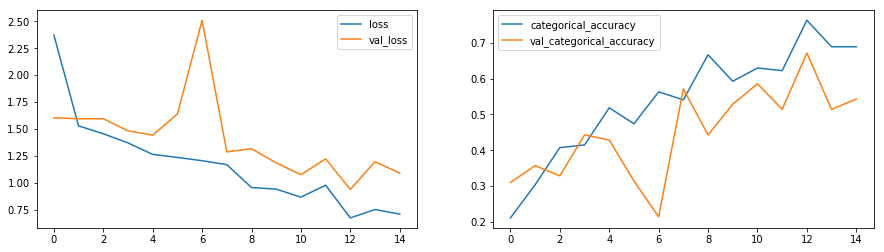

In [18]:
plot(history_3)

### Here we see val accuracy has increased to 54% we can try increasing the epochs & image resolution.

## Model 4 - Conv3d

### Lets check increasing image resolution while reducing batch_size

In [14]:
# custom parmeter
frame_count=16
img_y =160
img_z =160
num_epochs = 20
batch_size = 15
Conv3d_4_model= Conv3d_1.define_model(frame_count,img_y,img_z)
print (Conv3d_4_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 16, 160, 160, 32)  4128      
_________________________________________________________________
activation_17 (Activation)   (None, 16, 160, 160, 32)  0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 160, 160, 32)  128       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 80, 80, 32)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 80, 80, 64)    

In [22]:
history_4 = model_run(Conv3d_4_model,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

W0502 20:23:15.394320 139774090102592 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


frame_count= 16
Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 3.4892 - categorical_accuracy: 0.2112
Epoch 00001: val_loss improved from inf to 1.60409, saving model to Gesture_recog_2021-05-0219_55_32.561010/model-00001-3.48924-0.21116-1.60409-0.26000.h5
45/45 [==============================] - 61s 1s/step - loss: 3.4892 - categorical_accuracy: 0.2112 - val_loss: 1.6041 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 1.6070 - categorical_accuracy: 0.2296
Epoch 00002: val_loss did not improve from 1.60409
45/45 [==============================] - 18s 397ms/step - loss: 1.6070 - categorical_accuracy: 0.2296 - val_loss: 1.6065 - val_categorical_accuracy: 0.2429 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 1.5910 - categorical_accuracy: 0.2444
Epoch 00003: val_loss improved from 1.60409 to 1.59803, saving model to Gesture_recog_2021-05-0219_55_32.561010/model-00003-1

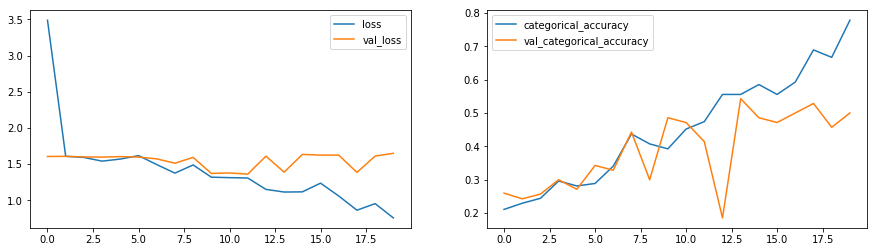

In [23]:
plot(history_4)

### Not much improvement in the validation accuracy hence we try ammending model adding some dropout & Maxpooling

## Model 5 - Conv3d_2

In [22]:
class Conv3d_2(tf.keras.Model):
    
    def define_model(frame_count, img_y, img_z):
        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',input_shape=(frame_count, img_y, img_z, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(32, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Conv3D(64, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))

        
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Flatten())
        model.add(Dropout(0.5))
        
        model.add(Dense(5,activation='softmax'))

        optimiser = optimizers.Adam()#write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

In [17]:
# custom parmeter
frame_count=16
img_y =160
img_z =160
num_epochs = 20
batch_size = 15
Conv3d_5_model= Conv3d_2.define_model(frame_count,img_y,img_z)
print (Conv3d_5_model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_24 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
activation_25 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 80, 80, 32)     128       
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 4, 40, 40, 32)    

In [18]:
history_5= model_run(Conv3d_5_model,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

W0502 20:59:28.593829 140348948789056 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


frame_count= 16
Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 1.5356 - categorical_accuracy: 0.3484
Epoch 00001: val_loss improved from inf to 1.56145, saving model to Gesture_recog_2021-05-0220_47_12.490505/model-00001-1.53559-0.34842-1.56145-0.35000.h5
45/45 [==============================] - 57s 1s/step - loss: 1.5356 - categorical_accuracy: 0.3484 - val_loss: 1.5615 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 1.5147 - categorical_accuracy: 0.3704
Epoch 00002: val_loss improved from 1.56145 to 1.55039, saving model to Gesture_recog_2021-05-0220_47_12.490505/model-00002-1.51471-0.37037-1.55039-0.40000.h5
45/45 [==============================] - 15s 336ms/step - loss: 1.5147 - categorical_accuracy: 0.3704 - val_loss: 1.5504 - val_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 1.2263 - categorical_accuracy: 0.4741
Epoch 00003: val_

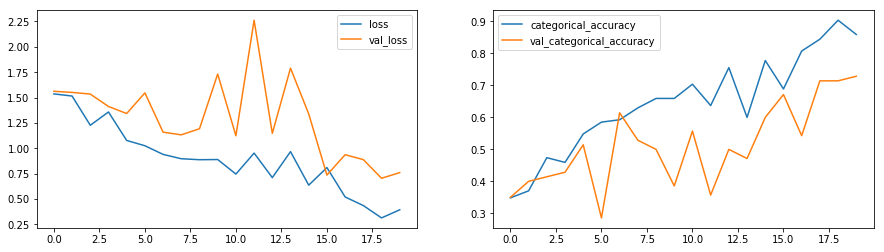

In [19]:
plot(history_5)

### Here we see it have improved a lot training accuracy 85% while validation accuracy its 72% hence overfitting

## Model 6 - Conv3d

### Further reducing the batch_size & increasing the epochs

In [20]:
# custom parmeter
frame_count=16
img_y =160
img_z =160
num_epochs = 25
batch_size = 10
Conv3d_6_model= Conv3d_2.define_model(frame_count,img_y,img_z)
print (Conv3d_6_model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_28 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
activation_29 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 80, 80, 32)     128       
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 4, 40, 40, 32)    

In [21]:
history_6= model_run(Conv3d_6_model,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

W0502 21:07:40.207706 140348948789056 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


frame_count= 16
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.5178 - categorical_accuracy: 0.3650
Epoch 00001: val_loss improved from inf to 1.55808, saving model to Gesture_recog_2021-05-0220_47_12.490505/model-00001-1.51775-0.36501-1.55808-0.38000.h5
67/67 [==============================] - 58s 863ms/step - loss: 1.5178 - categorical_accuracy: 0.3650 - val_loss: 1.5581 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2383 - categorical_accuracy: 0.4726
Epoch 00002: val_loss improved from 1.55808 to 1.54943, saving model to Gesture_recog_2021-05-0220_47_12.490505/model-00002-1.23828-0.47264-1.54943-0.46000.h5
67/67 [==============================] - 23s 341ms/step - loss: 1.2383 - categorical_accuracy: 0.4726 - val_loss: 1.5494 - val_categorical_accuracy: 0.4600 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.1726 - categorical_accuracy: 0.4876
Epoch 00003: v

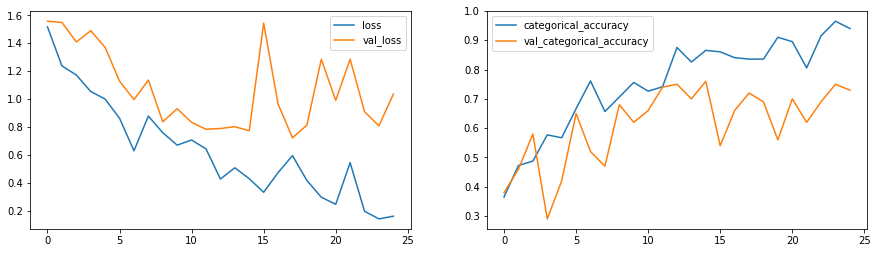

In [22]:
plot(history_6)

### This is clearly overfitting with training accuracy of 94% & val accuracy of 73%

### Model 7 - Conv3d_3

### Adding some more layers & increasing the batch_size

In [11]:
class Conv3d_3(tf.keras.Model):
    
    def define_model(frame_count, img_y, img_z):
        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',input_shape=(frame_count, img_y, img_z, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(32, (2,2,2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Conv3D(64, (2,2,2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Flatten())
        model.add(Dropout(0.5))
        
        model.add(Dense(5,activation='softmax'))

        optimiser = optimizers.Adam()#write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

In [12]:
# custom parmeter
frame_count=16
img_y =160
img_z =160
num_epochs = 25
batch_size = 10
Conv3d_7_model= Conv3d_3.define_model(frame_count,img_y,img_z)
print (Conv3d_7_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 160, 160, 16)  64        
_________________________________________________________________
activation_3 (Activation)    (None, 16, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 80, 80, 32)     128       
_________________________________________________________________
activation_4 (Activation)    (None, 8, 80, 80, 32)    

In [13]:
history_7= model_run(Conv3d_7_model,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

W0504 09:41:57.103522 139631855630144 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


frame_count= 16
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 10.2893 - categorical_accuracy: 0.4118
Epoch 00001: saving model to Gesture_recog_2021-05-0409_40_09.130841/model-00001-10.28927-0.41176-6.78218-0.28000.h5
67/67 [==============================] - 174s 3s/step - loss: 10.2893 - categorical_accuracy: 0.4118 - val_loss: 6.7822 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 10.4401 - categorical_accuracy: 0.5124
Epoch 00002: saving model to Gesture_recog_2021-05-0409_40_09.130841/model-00002-10.44011-0.51244-12.65469-0.31000.h5
67/67 [==============================] - 25s 370ms/step - loss: 10.4401 - categorical_accuracy: 0.5124 - val_loss: 12.6547 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 9.0230 - categorical_accuracy: 0.4925
Epoch 00003: saving model to Gesture_recog_2021-05-0409_40_09.130841/model-00003-9.02302-0

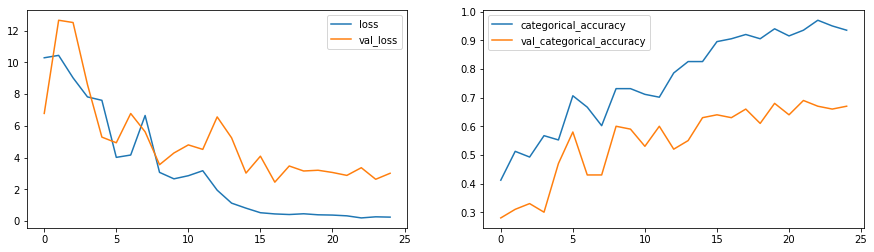

In [14]:
plot(history_7)

### Since we dont see much improvement we can try CNN RNN Model

##  CNN RNN Model

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM

class CNNRNN(tf.keras.Model):
    
    def ModelCNNRNN1(frame_count, img_y, img_z):

        model=Sequential()
        model.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),input_shape=(frame_count,img_y,img_z,3)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Conv2D(256,(3,3),padding='same',activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Conv2D(512,(3,3),padding='same',activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(128))
        model.add(Dropout(0.25))

        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.25))

        model.add(Dense(5,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

In [41]:
frame_count=18
img_y =120
img_z =120
batch_size=20
num_epochs=20
CNNRNN1= CNNRNN.ModelCNNRNN1(frame_count, img_y, img_z)
print (CNNRNN1.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_19 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_23 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_24 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 18, 30, 30, 64)  

In [43]:
history_8 = model_run(CNNRNN1,train_path,train_doc,val_path, val_doc,batch_size,frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

W0503 08:29:51.907495 139647666661184 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


frame_count= 18
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4345 - categorical_accuracy: 0.3620
Epoch 00001: saving model to Gesture_recog_2021-05-0308_27_00.795879/model-00001-1.43453-0.36199-1.89178-0.20000.h5
34/34 [==============================] - 129s 4s/step - loss: 1.4345 - categorical_accuracy: 0.3620 - val_loss: 1.8918 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5118 - categorical_accuracy: 0.4216
Epoch 00002: saving model to Gesture_recog_2021-05-0308_27_00.795879/model-00002-1.51176-0.42157-1.98343-0.16000.h5
34/34 [==============================] - 17s 492ms/step - loss: 1.5118 - categorical_accuracy: 0.4216 - val_loss: 1.9834 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.6290 - categorical_accuracy: 0.2255
Epoch 00003: saving model to Gesture_recog_2021-05-0308_27_00.795879/model-00003-1.62897-0.22549-1

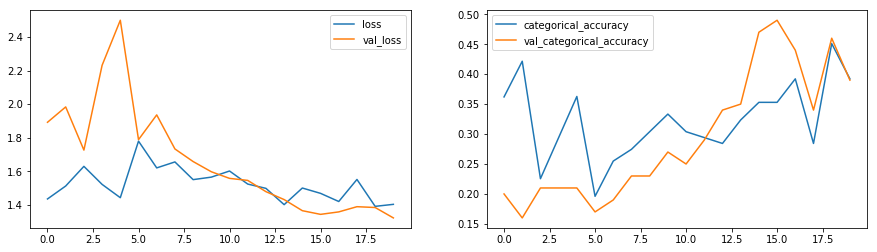

In [44]:
plot(history_8)

### the accuracy seems very low at 39% try tweaking some parameters

### So the CNN RNN Base Model 

## Model 9 - CNNRNN1

### Increasing the batch size & Image resolution

In [45]:
frame_count=24
img_y =160
img_z =160
batch_size=32
num_epochs=20

CNNRNN2= CNNRNN.ModelCNNRNN1(frame_count, img_y, img_z)
print (CNNRNN2.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_38 (TimeDis (None, 24, 160, 160, 16)  448       
_________________________________________________________________
time_distributed_39 (TimeDis (None, 24, 160, 160, 16)  64        
_________________________________________________________________
time_distributed_40 (TimeDis (None, 24, 80, 80, 16)    0         
_________________________________________________________________
time_distributed_41 (TimeDis (None, 24, 80, 80, 32)    4640      
_________________________________________________________________
time_distributed_42 (TimeDis (None, 24, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_43 (TimeDis (None, 24, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 24, 40, 40, 64)  

In [46]:
history_9 = model_run(CNNRNN2,train_path,train_doc,val_path, val_doc,batch_size,frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

W0503 08:50:39.189648 139647666661184 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


frame_count= 24
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.4732 - categorical_accuracy: 0.3544
Epoch 00001: saving model to Gesture_recog_2021-05-0308_27_00.795879/model-00001-1.47319-0.35445-1.65040-0.17000.h5
21/21 [==============================] - 140s 7s/step - loss: 1.4732 - categorical_accuracy: 0.3544 - val_loss: 1.6504 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.2437 - categorical_accuracy: 0.4596
Epoch 00002: saving model to Gesture_recog_2021-05-0308_27_00.795879/model-00002-1.24368-0.45963-2.59881-0.18750.h5
21/21 [==============================] - 91s 4s/step - loss: 1.2437 - categorical_accuracy: 0.4596 - val_loss: 2.5988 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.1824 - categorical_accuracy: 0.4865
Epoch 00003: saving model to Gesture_recog_2021-05-0308_27_00.795879/model-00003-1.18240-0.48654-2.37

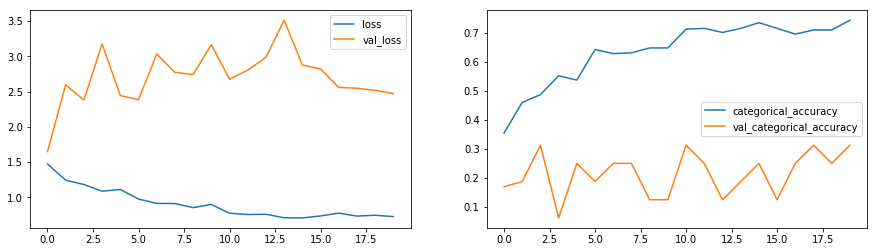

In [47]:
plot(history_9)

## Model 10 - GRU & MobileNet 

In [12]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class GRUMOB():
    
    def MODELGRUMOBILE(frame_count, img_y, img_z,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(frame_count,img_y,img_z,3)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

W0503 15:37:21.877672 140412778936128 mobilenet.py:216] `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


17227776/17225924 [==============================] - 0s 0us/step


In [19]:
frame_count=16
img_y =120
img_z =120
batch_size=5
num_epochs=20

GRUMOB1= GRUMOB.MODELGRUMOBILE(frame_count, img_y, img_z)
print (GRUMOB1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

In [20]:
history_10 = model_run(GRUMOB1,train_path,train_doc,val_path, val_doc,batch_size,frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

W0503 09:50:48.769515 139898132678464 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


frame_count= 16
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4514 - categorical_accuracy: 0.4118
Epoch 00001: val_loss improved from inf to 1.10154, saving model to Gesture_recog_2021-05-0309_23_54.123194/model-00001-1.45135-0.41176-1.10154-0.58000.h5
133/133 [==============================] - 51s 383ms/step - loss: 1.4514 - categorical_accuracy: 0.4118 - val_loss: 1.1015 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 1.3689 - categorical_accuracy: 0.4411
Epoch 00002: val_loss did not improve from 1.10154
133/133 [==============================] - 33s 247ms/step - loss: 1.3689 - categorical_accuracy: 0.4411 - val_loss: 1.2055 - val_categorical_accuracy: 0.4600 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 1.3036 - categorical_accuracy: 0.4561
Epoch 00003: val_loss did not improve from 1.10154
133/133 [==============================] - 33s 249ms/step - l

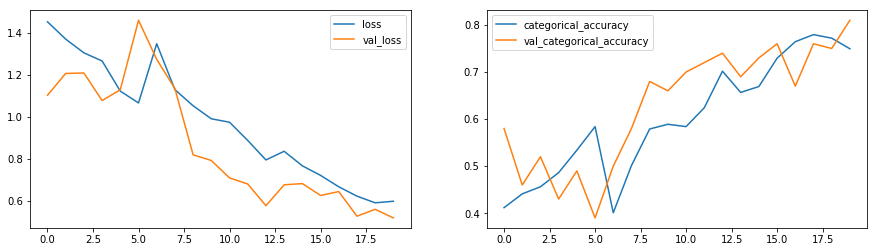

In [21]:
plot(history_10)

## Model 11 Increasing Batch Size & Epochs

In [13]:
frame_count=16
img_y =120
img_z =120
batch_size=10
num_epochs=25

GRUMOB2= GRUMOB.MODELGRUMOBILE(frame_count, img_y, img_z)
print (GRUMOB2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 64)                209280    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [14]:
history_11 = model_run(GRUMOB2,train_path,train_doc,val_path, val_doc,batch_size,frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

W0503 15:38:28.723511 140412778936128 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


frame_count= 16
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.1966 - categorical_accuracy: 0.5008
Epoch 00001: saving model to Gesture_recog_2021-05-0315_29_57.561746/model-00001-1.19659-0.50075-1.32031-0.52000.h5
67/67 [==============================] - 169s 3s/step - loss: 1.1966 - categorical_accuracy: 0.5008 - val_loss: 1.3203 - val_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2964 - categorical_accuracy: 0.4677
Epoch 00002: saving model to Gesture_recog_2021-05-0315_29_57.561746/model-00002-1.29635-0.46766-1.53328-0.27000.h5
67/67 [==============================] - 21s 316ms/step - loss: 1.2964 - categorical_accuracy: 0.4677 - val_loss: 1.5333 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.3808 - categorical_accuracy: 0.4229
Epoch 00003: saving model to Gesture_recog_2021-05-0315_29_57.561746/model-00003-1.38083-0.42289-1

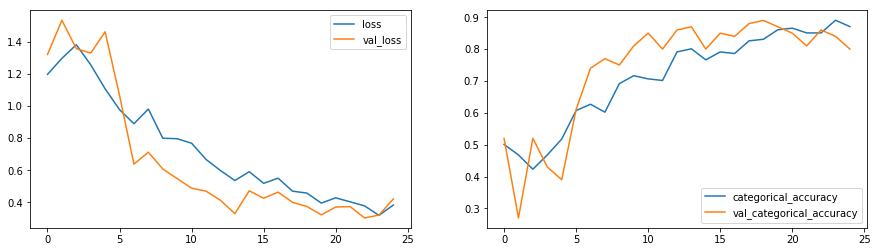

In [15]:
plot(history_11)

### Conclusion: This seems to be so far the best model & 0.89 & 0.84 @ 24th Epochs 